# Setting up the environment

In this section, we import all the necessary libraries that will be used in this notebook. These include libraries for data manipulation, machine learning model creation, evaluation, and visualization.

- **Numpy, Pandas**: For numerical computations and data handling.
- **Matplotlib**: For visualization.
- **Joblib**: To save and load models.
- **Scikit-learn**: To evaluate the model.
- **Mlxtend**: To perform feature selection.
- **XGBoost**: Our machine learning model.

In [1]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from xgboost import XGBRegressor

# Loading the dataset

We load the dataset using pandas. The dataset path is defined using the `dataset_name` and `reduction_method`.

In [2]:
# Load dataset
dataset_name = 'PD'
reduction_method = '_n1_c5_delta'
dataset_name1 = 'CF1'
reduction_method1 = '_n0.2_c6_delta1_YIELD'

base_path = 'Input'
info_path = 'Input/Info'
output_file = os.path.join('Input', f'{dataset_name}{reduction_method}.csv')
output_file1 = os.path.join('Input', f'{dataset_name1}{reduction_method1}.csv')

number_of_features = 30

In [3]:
# Read the CSV files
df1 = pd.read_csv(output_file)
# print("DF Columns:", df.columns)
print("DF Shape:", df1.shape)

df2 = pd.read_csv(output_file1)
# print("DF1 Columns:", df1.columns)
print("DF1 Shape:", df2.shape)

DF Shape: (4104, 65)
DF1 Shape: (23590, 60)


In [4]:
# Rename the column 'LTAY' to 'Mean' in df2
df2.rename(columns={'LTAY': 'Mean'}, inplace=True)
# print("Updated DF1 Columns:", df2.columns)

# Find common columns between df and df1
common_columns = list(set(df1.columns) & set(df2.columns))
# print("Common columns:", common_columns)

# Ensure required columns exist in both datasets
required_columns = ['FIELDID', 'Crop_type', 'Crop_num', 'Coverage', 'Mean']
available_columns = [col for col in required_columns if col in common_columns]

# Concatenate both datasets using the common columns
df = pd.concat([df1[common_columns], df2[common_columns]], ignore_index=True)

# Reorder columns to have the first four in the correct order
remaining_columns = [col for col in df.columns if col not in required_columns]
ordered_columns = required_columns + remaining_columns
df = df[ordered_columns]

# Print the shape and columns of the new dataset
print("New Dataset Shape:", df.shape)
print("New Dataset Columns:", df.columns)


New Dataset Shape: (27694, 60)
New Dataset Columns: Index(['FIELDID', 'Crop_type', 'Crop_num', 'Coverage', 'Mean', 's1_vv',
       'veg_min_evi', 'veg_median_evi', 'era5_rh', 'msi_delta1',
       'veg_std_ndvi', 'chirps_min_prec', 'ndvi_delta1', 'RSM_min',
       'veg_min_ndvi', 'era5_evaporation_from_bare_soil_sum',
       'chirps_mean_prec', 'chirps_max_prec', 'era5_temp2m', 's1_rvi',
       'veg_mean_msi', 'veg_max_pvr', 'era5_temp2max', 'chirps_cnt_prec',
       'pvr_delta1', 'veg_max_msi', 'veg_median_pvr', 'veg_mean_evi',
       'veg_mean_pvr', 'veg_std_lai', 'veg_median_ndvi', 'veg_median_lai',
       's1_rcspr', 'era5_totprec', 'week', 'era5_temp2mmin', 'lai_delta1',
       'veg_median_msi', 'veg_mean_ndvi', 'veg_mean_lai', 'veg_min_lai',
       'veg_min_pvr', 'veg_min_msi', 's1_angle', 's1_vh', 'veg_max_lai',
       'chirps_sum_prec', 'RSM_mean', 'era5_swi', 'veg_std_pvr',
       's1_sigma_vh_linear', 'veg_std_evi', 's1_p_ratio', 'veg_std_msi',
       'RSM_max', 's1_sigma_vv_l

In [5]:
# print the number of unique FIELDID for each Crop_type
print(df.groupby('Crop_type')['FIELDID'].nunique())
# save the printed data to a CSV file with name dataset_name_Fields_x_CropType.csv
df.groupby('Crop_type')['FIELDID'].nunique().to_csv(os.path.join(info_path, f'{dataset_name}_{dataset_name1}_Fields_x_CropType.csv'))


# print the number of rows for each Crop_type
print(df['Crop_type'].value_counts())
# save the printed data to a CSV file with name dataset_Obs_x_CropType.csv
df['Crop_type'].value_counts().to_csv(os.path.join(info_path, f'{dataset_name}_{dataset_name1}_Obs_x_CropType.csv'))



Crop_type
Lucern         12
Maize        6450
Soy           312
Sunflower     173
Wheat           6
Name: FIELDID, dtype: int64
Crop_type
Maize        19656
Soy           4890
Sunflower     2500
Lucern         487
Wheat          161
Name: count, dtype: int64


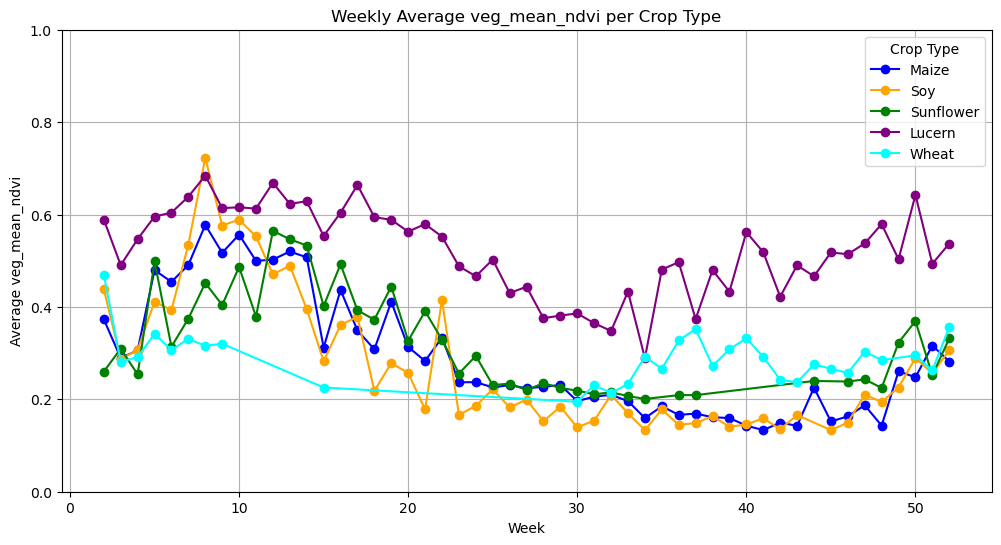

In [6]:
# Define fixed colors for crop types
crop_colors = {
    "Maize": "blue",
    "Soy": "orange",
    "Sunflower": "green",
    "Lucern": "purple",
    "Wheat": "cyan"
}

# Ensure 'week' and 'veg_mean_ndvi' are numeric
df["week"] = pd.to_numeric(df["week"], errors="coerce")
df["veg_mean_ndvi"] = pd.to_numeric(df["veg_mean_ndvi"], errors="coerce")

# Compute average veg_mean_ndvi per crop type per week
avg_ndvi_per_crop = df.groupby(["Crop_type", "week"], as_index=False)["veg_mean_ndvi"].mean()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each crop type's average NDVI time series
for crop in ["Maize", "Soy", "Sunflower", "Lucern", "Wheat"]:  # Ensure fixed order in legend
    if crop in avg_ndvi_per_crop["Crop_type"].unique():
        subset = avg_ndvi_per_crop[avg_ndvi_per_crop["Crop_type"] == crop].sort_values("week")
        
        # Convert to NumPy arrays to avoid indexing issues
        weeks = subset["week"].values
        ndvi_values = subset["veg_mean_ndvi"].values
        
        plt.plot(weeks, ndvi_values, marker="o", linestyle="-", label=crop, color=crop_colors[crop])

# Customize the plot
plt.xlabel("Week")
plt.ylabel("Average veg_mean_ndvi")
plt.title("Weekly Average veg_mean_ndvi per Crop Type")
plt.ylim(0, 1)
plt.legend(title="Crop Type", loc="best")
plt.grid(True)

# Show the plot
plt.show()



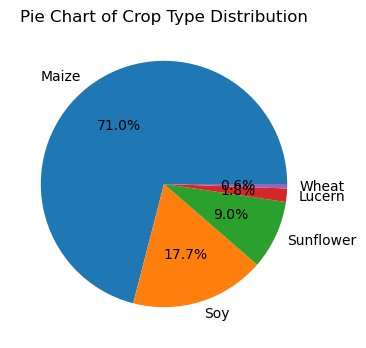

In [7]:
# plot pie chart for the distribution of the crop types
# plt.figure(figsize=(6, 6))
# df['Crop_type'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=[crop_colors[c] for c in df['Crop_type'].unique()])
# plt.title("Crop Type Distribution")
# plt.ylabel("")
# plt.show()

# Plot a pie chart of the Crop_type distribution 
plt.figure(figsize=(4, 4))
plt.pie(df['Crop_type'].value_counts(), labels=df['Crop_type'].value_counts().index, autopct='%1.1f%%')
plt.title('Pie Chart of Crop Type Distribution')
plt.show()

In [8]:
# print all the LTAY values for each Crop_type
print(df.groupby('Crop_type')['Mean'].unique())
# save the printed data to a CSV file with name dataset_name_LTAY_x_CropType.csv
df.groupby('Crop_type')['Mean'].unique().to_csv(os.path.join(info_path, f'{dataset_name}_LTAY_x_CropType.csv'))

Crop_type
Lucern                                            [12.0, 15.0]
Maize        [4.04, 1.72, 2.36, 5.06, 1.14, 1.75, 3.37, 0.6...
Soy          [2.78, 4.73, 1.42, 2.73, 2.84, 2.82, 3.89, 2.7...
Sunflower    [2.1, 1.3, 2.0, 1.8, 1.7, 1.5, 1.2, 1.0, 0.8, ...
Wheat                                                    [1.5]
Name: Mean, dtype: object


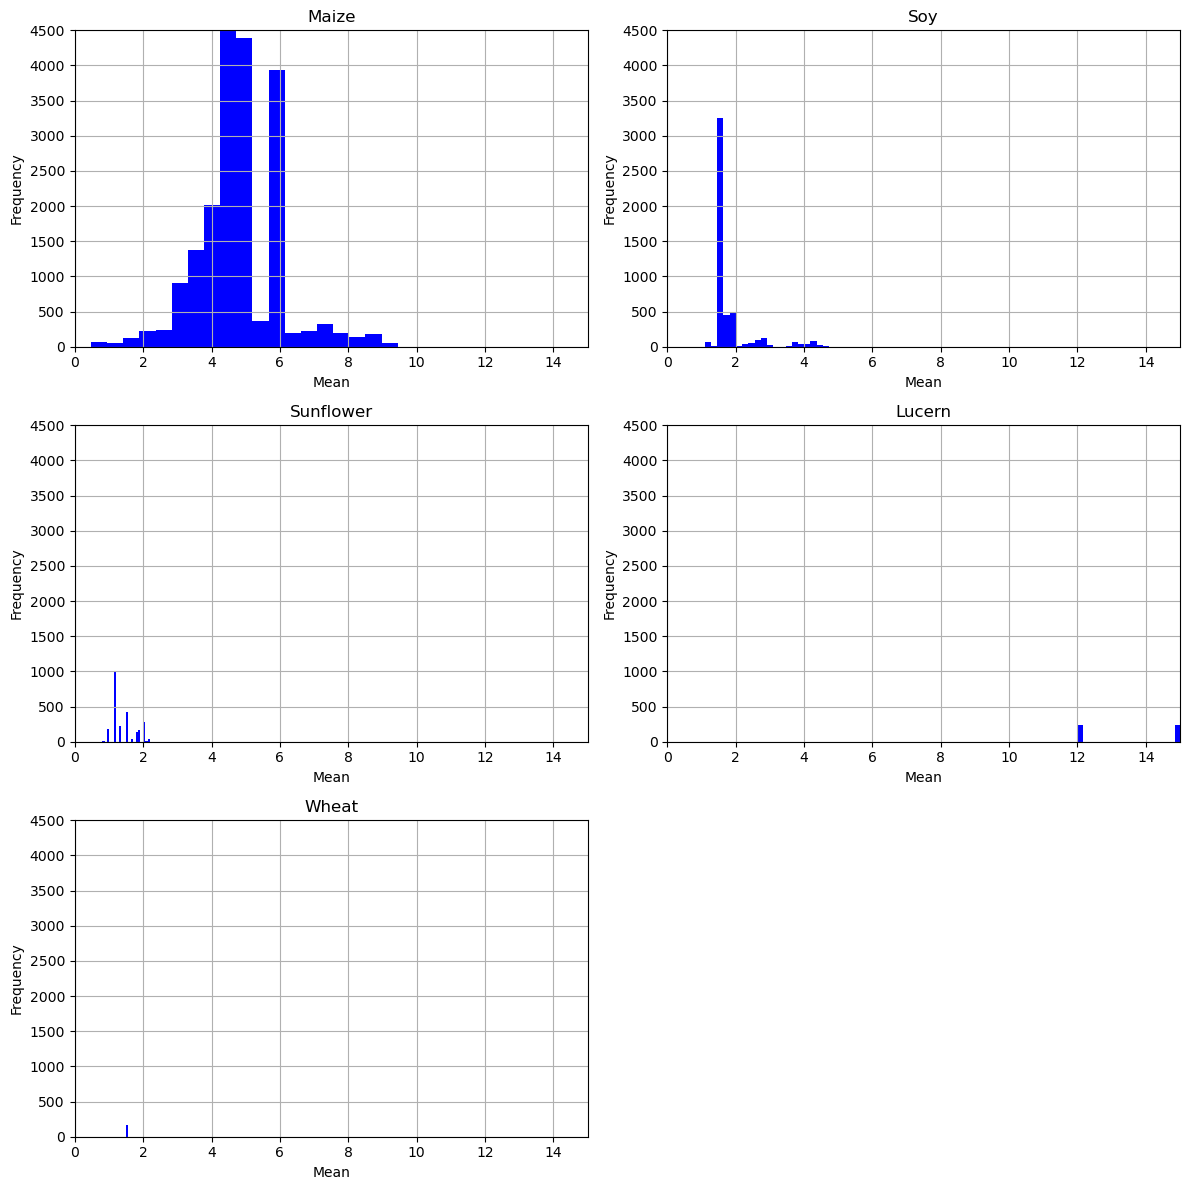

In [9]:
# for each crop type, make a histogram of the LTAY values in different plots
# group all the plots in one figure

plt.figure(figsize=(12, 12))
for i, crop in enumerate(["Maize", "Soy", "Sunflower", "Lucern", "Wheat"]):
    plt.subplot(3, 2, i + 1)
    plt.hist(df[df["Crop_type"] == crop]["Mean"], bins=20, color='blue')  # Set color to blue
    plt.title(crop)
    plt.xlabel("Mean")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.xlim(0, 15)
    plt.ylim(0, 4500)

plt.tight_layout()

plt.show()




In [10]:
# Save df_limited to a new CSV file
out_path = 'Input'
# use boosting factor in the output filename
output_filename = os.path.join(out_path, f'{dataset_name}_{dataset_name1}_n1_c5_delta.csv')
df.to_csv(output_filename, index=False)

In [11]:
# Group by 'CATNAME_1' and display unique irrigation values for each category
type_num = df[['Crop_type', 'Crop_num']].drop_duplicates()

# Print the unique categories and their corresponding irrigation values ordered by Crop_num
print(type_num.sort_values(by='Crop_num'))

       Crop_type  Crop_num
0          Maize         0
3402         Soy         1
25033  Sunflower         2
27533      Wheat         3
4104      Lucern         7
